# FNO

In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import UNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from neuralop.models import FNO

device = 'cpu'



In [5]:
import os
import numpy as np
os.chdir('c:\\Users\\cqyzxy\\Downloads\\jld\\jld')
import h5py
#f = h5py.File("hci_data.jld2", "r")
f = h5py.File("all_data_1d_glob.jld2", "r")
data_I = f['data_I']
data_c = f['data_c']
data_h = f['data_h']
data_I = torch.tensor(np.array(data_I))
data_c = torch.tensor(np.array(data_c))
data_h = torch.tensor(np.array(data_h))
#cat_ch = np.concatenate((data_c, data_h), axis=1)
#data_ch = torch.tensor(np.array(cat_ch))


In [6]:
data_I


tensor([[1.0000, 0.9866, 0.9842,  ..., 1.0105, 1.0106, 1.0106],
        [1.0000, 0.9857, 0.9828,  ..., 0.9810, 0.9810, 0.9810],
        [1.0000, 0.9926, 0.9906,  ..., 0.6850, 0.6846, 0.6841],
        ...,
        [1.0000, 0.9750, 0.9663,  ..., 0.7621, 0.7619, 0.7617],
        [1.0000, 0.9936, 0.9918,  ..., 0.7657, 0.7655, 0.7653],
        [1.0000, 0.9812, 0.9718,  ..., 1.0221, 1.0222, 1.0224]],
       dtype=torch.float64)

In [101]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Convert data to PyTorch tensors
data_I_tensor = torch.tensor(data_I, dtype=torch.float32)
data_c_tensor = torch.tensor(data_c, dtype=torch.float32)
data_h_tensor = torch.tensor(data_h, dtype=torch.float32)


# X_train, X_test, Y_train, Y_test = train_test_split(
#    data_I_tensor, data_c_tensor, test_size=0.2, random_state=42
# )

X_train, X_test, Y_train, Y_test = train_test_split(
    data_I_tensor, data_h_tensor, test_size=0.2, random_state=42
)



C:\Users\cqyzxy\AppData\Local\Temp\ipykernel_24724\2132973434.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_I_tensor = torch.tensor(data_I, dtype=torch.float32)
C:\Users\cqyzxy\AppData\Local\Temp\ipykernel_24724\2132973434.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_c_tensor = torch.tensor(data_c, dtype=torch.float32)
C:\Users\cqyzxy\AppData\Local\Temp\ipykernel_24724\2132973434.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_h_tensor = torch.tensor(data_h, dtype=torch.float32)


In [102]:

# Define the FNO model
operator = FNO(
    n_modes=(16,),         
    hidden_channels=64,    
    in_channels=1,        
    out_channels=1         
)


X_train_fno = X_train.unsqueeze(1) 
Y_train_fno = Y_train.unsqueeze(1) 
X_test_fno = X_test.unsqueeze(1)   
Y_test_fno = Y_test.unsqueeze(1)   

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(operator.parameters(), lr=0.001)



In [77]:
# Training loop
num_epochs = 5
batch_size = 32

# Create DataLoaders for batching
train_loader = torch.utils.data.DataLoader(
    list(zip(X_train_fno, Y_train_fno)), batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    list(zip(X_test_fno, Y_test_fno)), batch_size=batch_size, shuffle=False
)

for epoch in range(num_epochs):
    operator.train()  
    epoch_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad() 
        predictions = operator(inputs)  
        loss = criterion(predictions, targets)  
        loss.backward()  
        optimizer.step() 
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

# Evaluate on test set
operator.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = operator(inputs)
        loss = criterion(predictions, targets)
        test_loss += loss.item()
print(f"Test Loss: {test_loss / len(test_loader)}")


Epoch 1/5, Loss: 0.012713402488094582
Epoch 2/5, Loss: 0.01249789003448476
Epoch 3/5, Loss: 0.013549464780870279
Epoch 4/5, Loss: 0.01243681971639046
Epoch 5/5, Loss: 0.012147771697342206
Test Loss: 0.015746247992169535


# Save model

In [92]:
#torch.save(operator.state_dict(), "final_h_model.pth")
torch.save(operator.state_dict(), "final_c_model.pth")


In [124]:
all_predictions = []
all_targets = []
operator = FNO(n_modes=(16,), hidden_channels=64, in_channels=1, out_channels=1)
operator.load_state_dict(torch.load("final_h_model.pth"))
operator.eval()
train_loader = torch.utils.data.DataLoader(
    list(zip(X_train_fno, Y_train_fno)), batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    list(zip(X_test_fno, Y_test_fno)), batch_size=batch_size, shuffle=False
)
with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = operator(inputs)
        all_predictions.append(predictions)
        all_targets.append(targets)

# Concatenate all predictions and targets along the batch dimension
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

print(f"Predictions shape: {all_predictions.shape}")
print(f"Targets shape: {all_targets.shape}")


C:\Users\cqyzxy\AppData\Local\Temp\ipykernel_24724\451055495.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  operator.load_state_dict(torch.load("final_h_model.pth"))


Predictions shape: torch.Size([4739, 1, 601])
Targets shape: torch.Size([4739, 1, 601])


# Plotting 3*3 cases over t = (0,1)

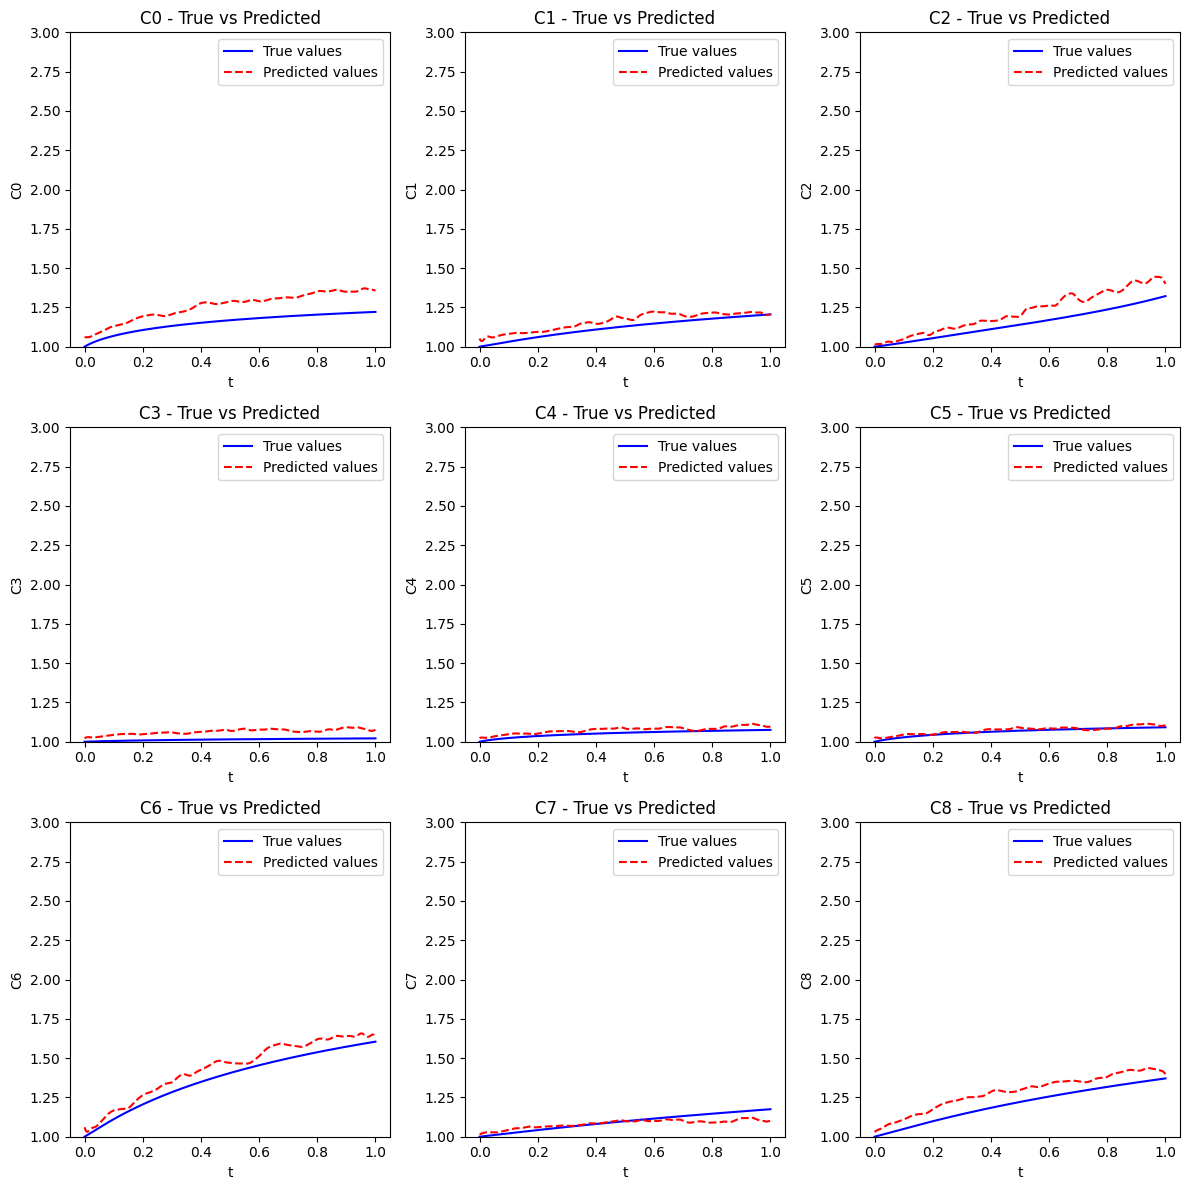

In [80]:
import matplotlib.pyplot as plt


# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

x = np.linspace(0, 1, 601) 

for i in range(9): 
    row, col = divmod(i, 3)  
    ax = axes[row, col]  

    # Plot true vs predicted values for the i-th feature
    ax.plot(x,all_targets[40*i,:].squeeze(), label="True values", color="b")
    ax.plot(x,all_predictions[40*i,:].squeeze(), label="Predicted values", color="r", linestyle="--")
    
    ax.set_xlabel("t")
    ax.set_ylabel(f"C{i}")
    ax.set_title(f"C{i} - True vs Predicted")
    
    ax.set_ylim(1, 3)
    
    ax.legend()
fig.tight_layout()

plt.show()

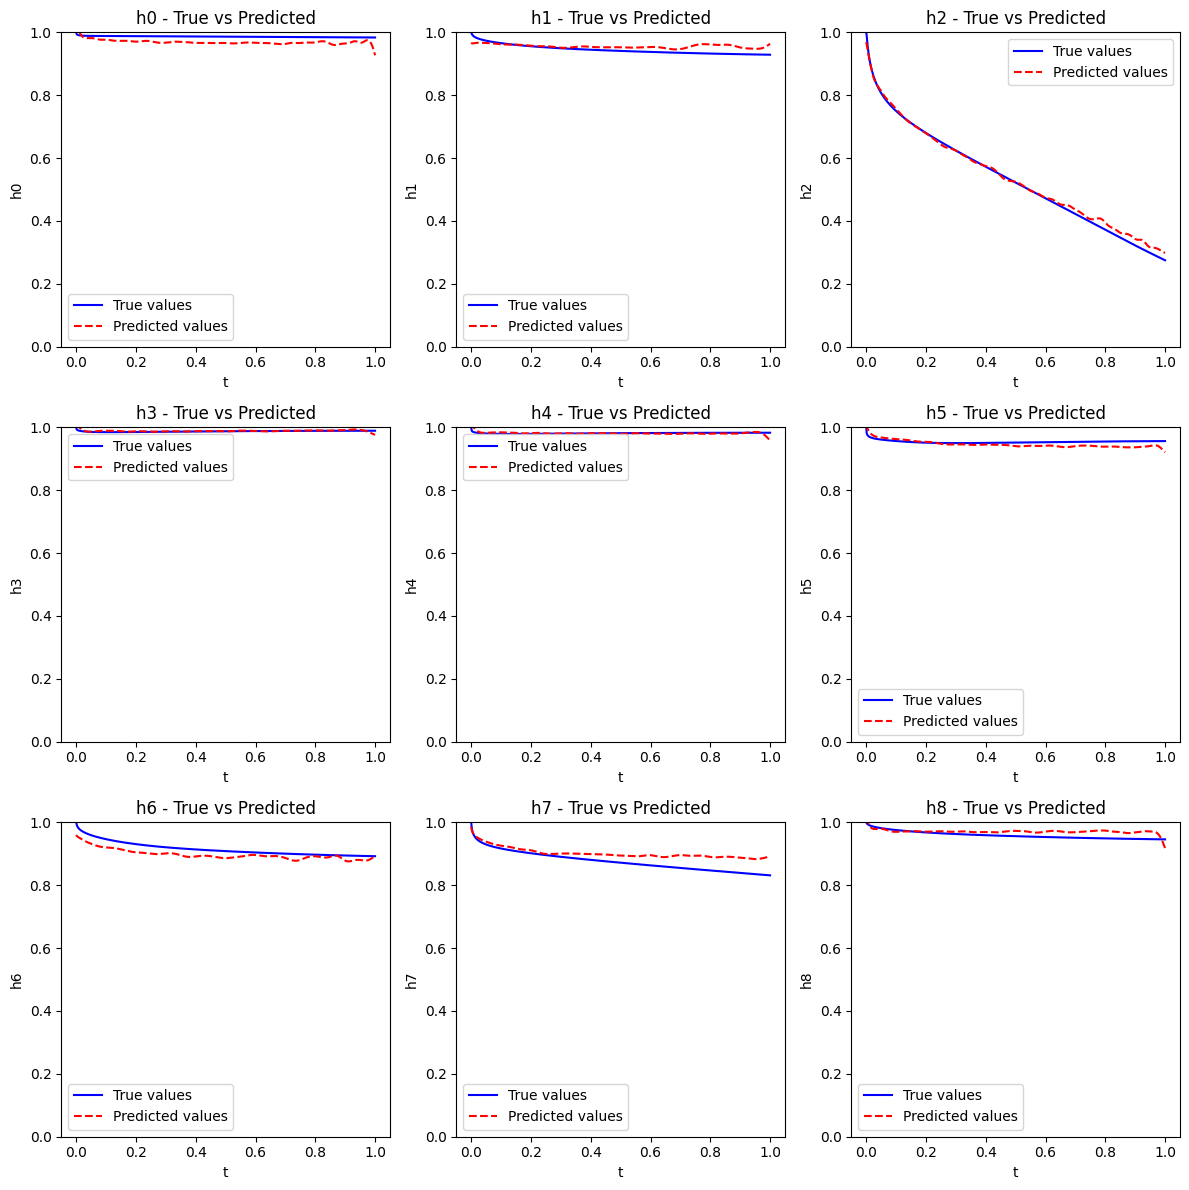

In [123]:
import matplotlib.pyplot as plt


# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
x = np.linspace(0, 1, 601) 

for i in range(9): 
    row, col = divmod(i, 3) 
    ax = axes[row, col] 

    # Plot true vs predicted values for the i-th feature
    ax.plot(x,all_targets[40*i,:].squeeze(), label="True values", color="b")
    ax.plot(x,all_predictions[40*i,:].squeeze(), label="Predicted values", color="r", linestyle="--")
    
    ax.set_xlabel("t")
    ax.set_ylabel(f"h{i}")
    ax.set_title(f"h{i} - True vs Predicted")

    ax.set_ylim(0, 1)
    ax.legend()

fig.tight_layout()
plt.show()


# Error Plots

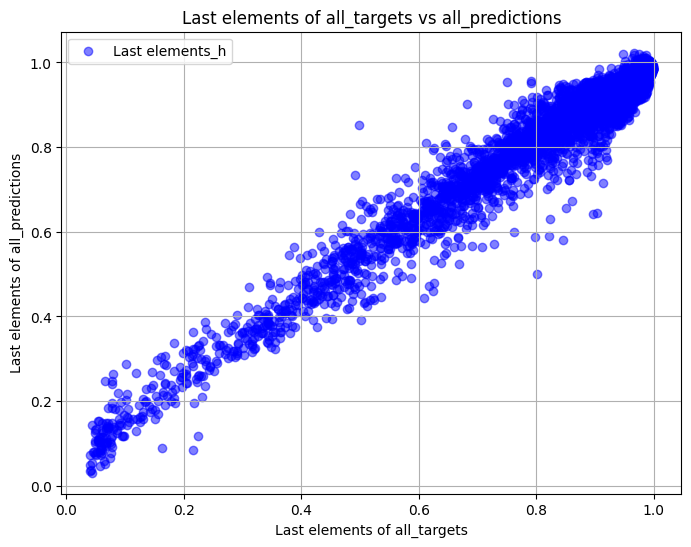

In [117]:
last_targets = all_targets[:, 0, -1]
last_predictions = all_predictions[:, 0, -1]

# Plot last elements of all_targets vs all_predictions
plt.figure(figsize=(8, 6))
plt.scatter(last_targets, last_predictions, color='blue', label='Last elements_h', alpha=0.5)
#plt.plot([min(last_targets), max(last_targets)], [min(last_targets), max(last_targets)], 'r--', label='y = x')
plt.xlabel('Last elements of all_targets')
plt.ylabel('Last elements of all_predictions')
plt.title('Last elements of all_targets vs all_predictions')
plt.legend()
plt.grid(True)
plt.show()


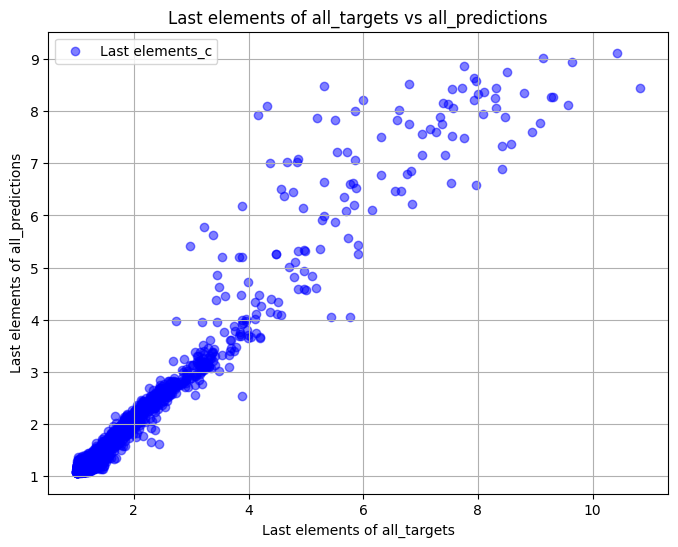

In [91]:
last_targets = all_targets[:, 0, -1]
last_predictions = all_predictions[:, 0, -1]

# Plot last elements of all_targets vs all_predictions
plt.figure(figsize=(8, 6))
plt.scatter(last_targets, last_predictions, color='blue', label='Last elements_c', alpha=0.5)
#plt.plot([min(last_targets), max(last_targets)], [min(last_targets), max(last_targets)], 'r--', label='y = x')
plt.xlabel('Last elements of all_targets')
plt.ylabel('Last elements of all_predictions')
plt.title('Last elements of all_targets vs all_predictions')
plt.legend()
plt.grid(True)
plt.show()

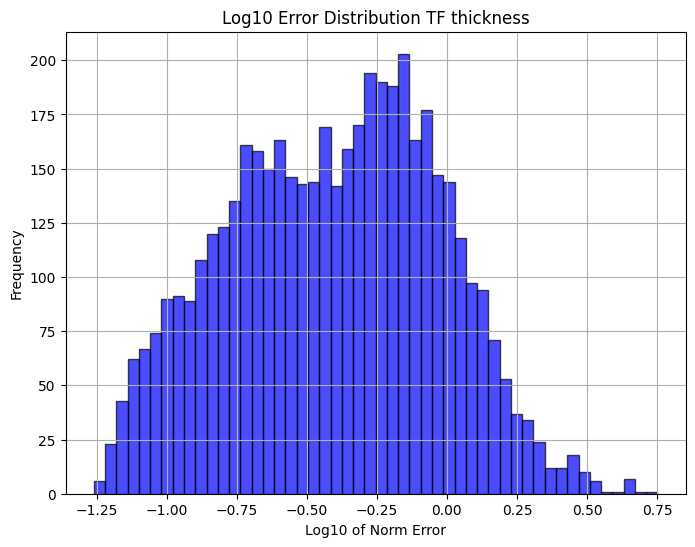

In [ ]:
error = all_targets - all_predictions

norm_error = torch.norm(error, p=2, dim=2)  

log_norm_error = torch.log10(norm_error)

log_norm_error_flattened = log_norm_error.flatten()

plt.figure(figsize=(8, 6))
plt.hist(log_norm_error_flattened.numpy(), bins=50, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Log10 of Norm Error')
plt.ylabel('Frequency')
plt.title('Log10 Error Distribution TF thickness')
plt.grid(True)
plt.show()


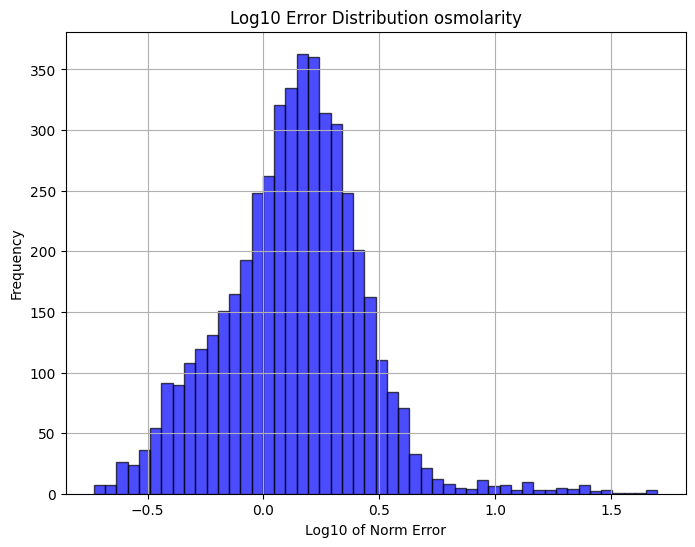

In [90]:
error = all_targets - all_predictions

norm_error = torch.norm(error, p=2, dim=2)  

log_norm_error = torch.log10(norm_error)

# Flatten the log norm error tensor to a 1D array (though norm_error is already 1D)
log_norm_error_flattened = log_norm_error.flatten()

# Plot the binned log norm error as a probability distribution
plt.figure(figsize=(8, 6))
plt.hist(log_norm_error_flattened.numpy(), bins=50, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Log10 of Norm Error')
plt.ylabel('Frequency')
plt.title('Log10 Error Distribution osmolarity')
plt.grid(True)
plt.show()
